# Machine Learning Project

# Overview
## Introduction

Machine learning is an emerging technology with a growing relevance in medicine. With the wealth of medical data that's becoming available it is now possible to use machine learning to assist in diagnosing disease, however these predictions need to be very accurate as a patient's health is of the greatest concern. It is therefore necessary to rigorously test any machine learning models in this domain to determine which, if any, performs best.

The aim of this project is to determine which of 4 machine learning models best predicts the presence of heart disease using a dataset obtained from the UCI Machine Learning repository. The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/statlog+%28heart%29). 

## Aims and Methodology

In this study we will examine 4 different models to determine which performs best. The 4 models are k-nearest neighbors, decision trees, naive bayes, and random forests. 

After preliminary data preparation and exploration, we partition our dataset into training and testing sets. 

Once our data is ready, prior to testing, we do some optimisation: 
* we perform feature selection to determine an optimal subset of descriptive features.
* we then perform hyperparameter tuning using grid search on the training dataset to optimise the parameters of our models.

When our models are optimised we perform cross-validation on each of the optimised models using the testing data to obtain a measure of their performance. These scores are then analysed using paired t-tests to determine their significance.

We conclude with a discussion.

## Table Of Contents:
* [Data Description](#data-desc)
* [Data Preparation](#dataprep)
* [Data Exploration & Visualisation](#datavis)
* [Predictive Modelling](#pred-mod)
    * [Cross-Validation](#cross-val)
    * [Feature Selection](#feature-sel)
    * [Hyperparameter Tuning](#hyper-tun)
* [Model Fitting and Performance Evaluation](#model-fit)
* [Discussion](#discussion)
    * [Confusion Matrix, precision, recall and F1-score](#conf-mat)
    * [ROC Curve](#roc-curve)
* [Conclusion](#conclusion)
* [References](#refs)

<a class="anchor" id="data-desc"></a>
# Data Description

Our data consists of 270 instances with 13 descriptive features, and a target feature having two classes which indicate the presence or absence of heart disease. Hence, this is a binary classification problem. As is, our dataset contains no missing values.

The following explanation of the descriptive features is extracted from the dataset description on the [UCI website](https://archive.ics.uci.edu/ml/datasets/statlog+%28heart%29) (note that the last descriptive feature 'thal' does not come with any information as to its meaning):
* age - **numerical**
* sex - **binary**
* chest pain type - **nominal**
* resting blood pressure - **numerical**
* serum cholestoral in mg/dl - **numerical**      
* fasting blood sugar > 120 mg/dl - **binary**
* resting electrocardiographic results - **nominal**
* maximum heart rate achieved - **numerical**
* exercise induced angina - **binary**
* oldpeak = ST depression induced by exercise relative to rest - **numerical**
* the slope of the peak exercise ST segment - **ordinal**
* number of major vessels (0-3) colored by flourosopy - **numerical**    
* thal (3 = normal; 6 = fixed defect; 7 = reversible defect) - **nominal**

One thing that we observed in this dataset is that each of the nominal features has been integer encoded, which is a miselading representation of the data and will be addressed in the processing stage. 

Time to import our dataset as well as any modules we will be using, and do some preliminary configuration.

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
# for plotting
#!pip install --upgrade pip
#!pip install --upgrade altair
#!pip install vega vega_datasets

In [90]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [91]:
import pandas as pd
import numpy as np

# ignore python warnings
import warnings
warnings.filterwarnings('ignore')

# set random state for reproducibility
random_seed = 999

# display all columns
pd.set_option('display.max_columns', None) 

# handle figure numbers
fignr = list(range(1,100))

# read in and configure data with column names
# column names are abbreviated below for space
col_names = ['age', 'sex', 'cpt', 'rb', 'sc', 'fbs', 'rer', 'mha', 'eia', 'old', 'sope', 'nomv', 'thal', 'target'] 
full_data = pd.read_csv('heart.csv',names=col_names,header=None)

# separate target feature
target = full_data['target']
data = full_data.copy()
data.drop(columns=['target'],inplace=True)

In [92]:
full_data.head()

,age,sex,cpt,rb,sc,fbs,rer,mha,eia,old,sope,nomv,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


Now that we have our dataset imported and our target feature separated we can have a brief look at our dataset using python.

In [93]:
print("----------")
print(f"Shape of the dataset is {data.shape} \n")
print("----------")
print(f"Each of the descriptive features have the following types:\n{data.dtypes}\n")
print("----------")
print(f"Each of the descriptive features have the following number of unique values:\n{data.nunique()}\n")
print("----------")
print(f"The dataset contains no missing values:\n{data.isna().sum()}\n")

----------
Shape of the dataset is (270, 13) 

----------
Each of the descriptive features have the following types:
age     float64
sex     float64
cpt     float64
rb      float64
sc      float64
fbs     float64
rer     float64
mha     float64
eia     float64
old     float64
sope    float64
nomv    float64
thal    float64
dtype: object

----------
Each of the descriptive features have the following number of unique values:
age      41
sex       2
cpt       4
rb       47
sc      144
fbs       2
rer       3
mha      90
eia       2
old      39
sope      3
nomv      4
thal      3
dtype: int64

----------
The dataset contains no missing values:
age     0
sex     0
cpt     0
rb      0
sc      0
fbs     0
rer     0
mha     0
eia     0
old     0
sope    0
nomv    0
thal    0
dtype: int64



<a class="anchor" id="dataprep"></a>
# Data Preparation

While our dataset comes to us fairly clean, there is still much data preparation to do before we can get to the business of predictive modelling.

First of all, we must integer encode the target feature. It currently holds the values (1) for the absence of heart disease, and (2) for the presence of heart disease. Since the presence is our postive feature, we wish to map this to (1) and the absence to (0).

In [94]:
# firstly we integer encode target feature 
print("Target before encoding: ",np.unique(target,return_counts=True))
encoded_target = np.where(target==1,0,1)
print("Target after encoding: ",np.unique(encoded_target,return_counts=True))

Target before encoding:  (array([1, 2]), array([150, 120]))
Target after encoding:  (array([0, 1]), array([150, 120]))


We now turn to our nominal features (chest pain type, resting electrocardiographic results, and thal) which have been integer encoded. As integer encoding assumes an ordering, we consider it bad practice to integer encode nominal features, so we will undo this encoding to repace it with a one-hot encoding scheme.

In [95]:
# output the value counts for variable 'cpt'
print(f"Before processing the variable \"cpt\" has the following value counts:\n{data['cpt'].value_counts()}\n")

# we then map each of them to the following categorical levels
cpt_mappings = {1.0 : 'cpt1', 2.0 : 'cpt2', 3.0 : 'cpt3', 4.0 : 'cpt4'}
data['cpt'].replace(cpt_mappings,inplace=True)

# output the result
print(f"After processing the variable \"cpt\" has the following value counts:\n{data['cpt'].value_counts()}\n")

# output the value counts for variable 'rer'
print(f"Before processing the variable \"rer\" has the following value counts:\n{data['rer'].value_counts()}\n")

# we then map each of them to the following categorical levels
rer_mappings = {0.0 : 'rer0', 1.0 : 'rer1', 2.0 : 'rer2'}
data['rer'].replace(rer_mappings,inplace=True)

# output the result
print(f"After processing the variable \"rer\" has the following value counts:\n{data['rer'].value_counts()}\n")

# output the value counts for variable 'thal'
print(f"Before processing the variable \"thal\" has the following value counts:\n{data['thal'].value_counts()}\n")

# we then map each of them to the following categorical levels
thal_mappings = {3.0 : 'thal3', 6.0 : 'thal6', 7.0 : 'thal7'}
data['thal'].replace(thal_mappings,inplace=True)

# output the result
print(f"After processing the variable \"thal\" has the following value counts:\n{data['thal'].value_counts()}\n")

Before processing the variable "cpt" has the following value counts:
4.0    129
3.0     79
2.0     42
1.0     20
Name: cpt, dtype: int64

After processing the variable "cpt" has the following value counts:
cpt4    129
cpt3     79
cpt2     42
cpt1     20
Name: cpt, dtype: int64

Before processing the variable "rer" has the following value counts:
2.0    137
0.0    131
1.0      2
Name: rer, dtype: int64

After processing the variable "rer" has the following value counts:
rer2    137
rer0    131
rer1      2
Name: rer, dtype: int64

Before processing the variable "thal" has the following value counts:
3.0    152
7.0    104
6.0     14
Name: thal, dtype: int64

After processing the variable "thal" has the following value counts:
thal3    152
thal7    104
thal6     14
Name: thal, dtype: int64



Now that we've undone the integer encoding, we're ready to apply one-hot encoding to these nominal variables.

In [96]:
# one-hot encode
data = pd.get_dummies(data)
# display transformed data
print(f"The shape of the one-hot encoded data is {data.shape}\n")
data.head()

The shape of the one-hot encoded data is (270, 20)



,age,sex,rb,sc,fbs,mha,eia,old,sope,nomv,cpt_cpt1,cpt_cpt2,cpt_cpt3,cpt_cpt4,rer_rer0,rer_rer1,rer_rer2,thal_thal3,thal_thal6,thal_thal7
0,70.0,1.0,130.0,322.0,0.0,109.0,0.0,2.4,2.0,3.0,0,0,0,1,0,0,1,1,0,0
1,67.0,0.0,115.0,564.0,0.0,160.0,0.0,1.6,2.0,0.0,0,0,1,0,0,0,1,0,0,1
2,57.0,1.0,124.0,261.0,0.0,141.0,0.0,0.3,1.0,0.0,0,1,0,0,1,0,0,0,0,1
3,64.0,1.0,128.0,263.0,0.0,105.0,1.0,0.2,2.0,1.0,0,0,0,1,1,0,0,0,0,1
4,74.0,0.0,120.0,269.0,0.0,121.0,1.0,0.2,1.0,1.0,0,1,0,0,0,0,1,1,0,0


Now that our descriptive features are encoded correctly we can scale our data.

In [97]:
from sklearn import preprocessing

# copy the processed data
data_copy = data.copy()

# perform scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data = scaler.fit_transform(data)

Our data has now been processed and scaled and we're ready to move to the next section.

<a class="anchor" id="datavis"></a>
# Data Exploration & Visualisation

Let's take a closer look at our dataset and examine some of our descriptive features. Note that we will be referring to a copy of the original data with full column names for ease of examination, and to not interfere with data prepared for modelling. This data is shown below.

In [98]:
col_names = ['age', 'sex', 'chest pain type', 'resting bp', 'serum cholestoral', 
'fasting blood sugar', 'resting ecg results', 'max hr achieved', 'exercise induced angina', 
'oldpeak', 'slope of peak exercise', 'no of major vessels', 'thal', 'target']
data2 = full_data.copy()
data2.columns = col_names

# Encoding target (1,2) which means absence/presence of heart disease to (0,1) according to discussion above
df_temp = data2.assign(encoded_target=(data2['target'] + 1) % 2)
data2['target'] = df_temp['encoded_target']
data2.head()

,age,sex,chest pain type,resting bp,serum cholestoral,fasting blood sugar,resting ecg results,max hr achieved,exercise induced angina,oldpeak,slope of peak exercise,no of major vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


Below we show the distribution of values for gender as well as for that of chest pain type.

Analysing the plots below reveals some imbalances:

- There is roughly double the amount of gender 1.0 than 0.0 
- The chest pain type 1.0 has about 20 patients which is quite a small sample
- The thal type 6.0 have very few patients and should be considered when handling the thal feature

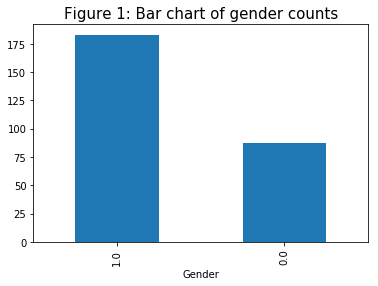

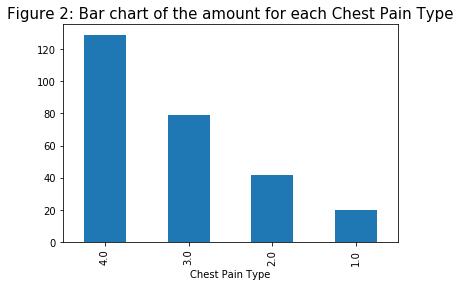

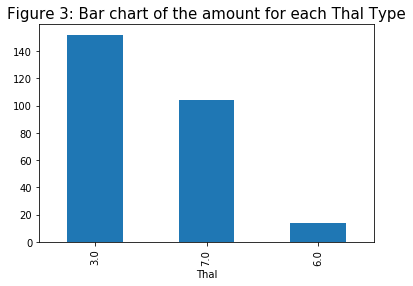

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = data2['sex'].value_counts().plot(kind = 'bar')
plt.title('Figure {}: Bar chart of gender counts'.format(fignr.pop(0)), fontsize = 15)
plt.xlabel('Gender')
plt.show()

# the distribution of each of the chest pain types
ax = data2['chest pain type'].value_counts().plot(kind = 'bar')
plt.title('Figure {}: Bar chart of the amount for each Chest Pain Type'.format(fignr.pop(0)), fontsize = 15)
plt.xlabel('Chest Pain Type')
plt.show()

# the distribution of each of the thal types
ax = data2['thal'].value_counts().plot(kind = 'bar')
plt.title('Figure {}: Bar chart of the amount for each Thal Type'.format(fignr.pop(0)), fontsize = 15)
plt.xlabel('Thal')
plt.show()

The boxplot below shows that the median age is around 55 years with an interquartile range of around 48 to 62 years. It is not skewed in any directions, but according to histogram plot below the data is not normal distribution.

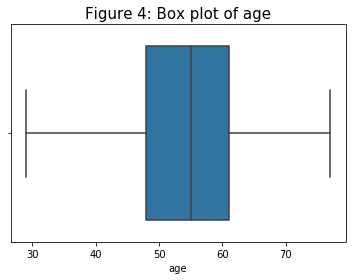

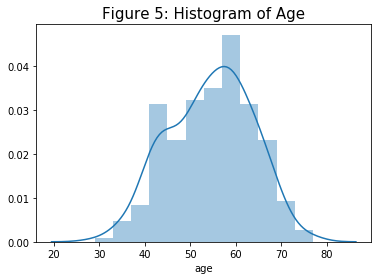

In [100]:
# Boxplot of distribution of age
sns.boxplot(data2['age']).set_title('Figure {}: Box plot of age'.format(fignr.pop(0)), fontsize = 15)
plt.show();

# Histogram plot of distribution of age with kernel density
sns.distplot(data2['age'], kde = True).set_title('Figure {}: Histogram of Age'.format(fignr.pop(0)), fontsize = 15)
plt.show();

The following histogram shows the probability (y-axis) of each resting blood pressure (x-axis) with the line showing the kernel density. The boxplot below shows that the median of the resting bloodpressure is around 130.

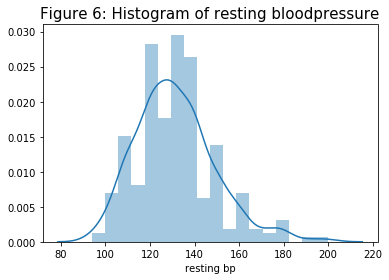

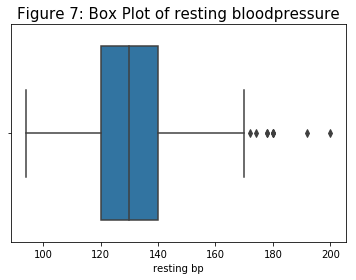

In [101]:
feature = 'resting bp'
sns.distplot(data2[feature], kde = True).set_title('Figure {}: Histogram of resting bloodpressure'.format(fignr.pop(0)), fontsize = 15)
plt.show();
sns.boxplot(data2[feature]).set_title('Figure {}: Box Plot of resting bloodpressure'.format(fignr.pop(0)), fontsize = 15)
plt.show();

The figure below show that the distribution of ages within each gender is similar, but with a slight difference where gender '1.0' is on average younger than gender '0.0', and have a wider distribution. 

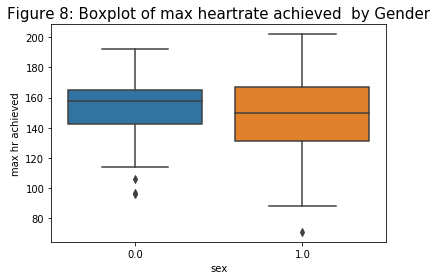

In [102]:
# Box plot of the amount of each gender 
sns.boxplot(data2['sex'], data2['max hr achieved']);
plt.title('Figure {}: Boxplot of max heartrate achieved  by Gender'.format(fignr.pop(0)), fontsize = 15)
plt.show();

Below we will combine some of our numerical features to determine their relationship to our target feature. Our numerical features are: age, resting bp, serum cholestoral number, max heart rate achieved, and old peak.

From the boxplots below we infer that patients diagnosed with heart disease in general have:

- A higher age
- A higher resting blood pessure
- Approximately the same serum cholestoral
- A significantly lower achieved maximum heart rate
- A significantly higher oldpeak value (ST depression induced by exercise relative to rest)

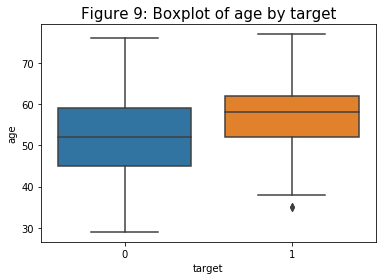

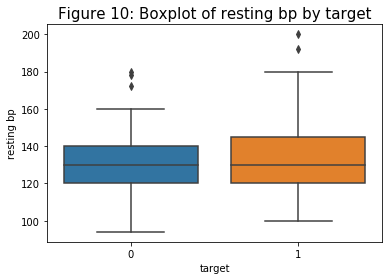

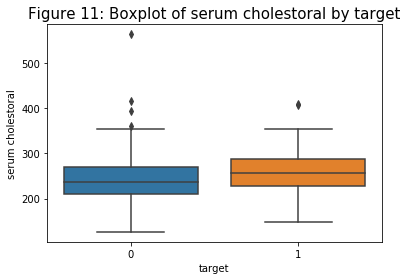

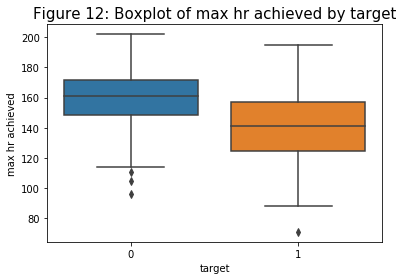

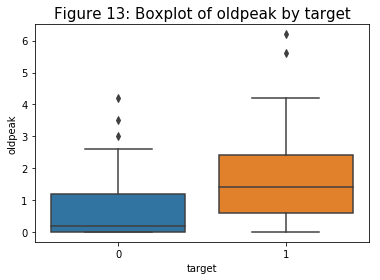

In [103]:
def show_2feature_boxplot(data, f1_nom=None, f2_num=None):
    sns.boxplot(data[f1_nom], data2[f2_num]);
    plt.title('Figure {}: Boxplot of {} by {}'.format(fignr.pop(0), f2_num, f1_nom), fontsize = 15)
    plt.show();

# show_2feature_boxplot(data2, f1_nom='sex', f2_num='resting bp')
# TODO: these need to be separated into separate frames!
show_2feature_boxplot(data2, f1_nom='target', f2_num='age')
show_2feature_boxplot(data2, f1_nom='target', f2_num='resting bp')
show_2feature_boxplot(data2, f1_nom='target', f2_num='serum cholestoral')
show_2feature_boxplot(data2, f1_nom='target', f2_num='max hr achieved')
show_2feature_boxplot(data2, f1_nom='target', f2_num='oldpeak')

Here we use multivariate plots to analyse the relationship between our target feature and some of our categorical features, which include: sex/gender, chest pain type, fasting blood sugar, resting ecg results, exercise induced angina, slope of peak exercise, no of major vessels and thal. 

Below is the combination of age (numerical), chest pain type (nominal, 4 levels) and sex (nominal, 2 levels) combined. The result shows that difference of age with the different chest pain types varies a lot more with gender 0.0 than for gender 1.0

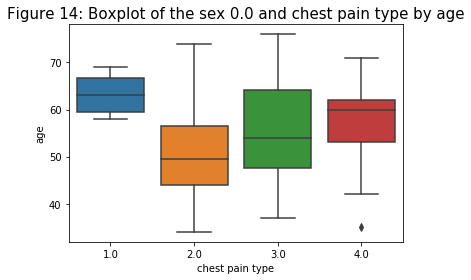

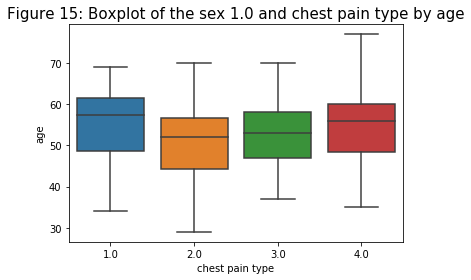

In [104]:
# Show 3 features, where one is numerical (f1) and two is nominal (f2, f3) with only one chosen level on the latter feature (f3)
def show_3feature_boxplot(data, f1, f2, f3, f3_level):
    levels = data[f2].unique().tolist()
    
    # Make a mask of f2 and f3 with f3's chosen level
    mask = (data[f2].isin(levels)) & (data[f3].isin([f3_level]))
    mask_level = data[mask]
    sns.boxplot(mask_level[f2], mask_level[f1]);
    plt.title('Figure {}: Boxplot of the {} {} and {} by {}'.format(fignr.pop(0), f3, f3_level, f2, f1), fontsize = 15)
    plt.show();

# Showing two plots for each gender
show_3feature_boxplot(data2, 'age', 'chest pain type', 'sex', '0.0')
show_3feature_boxplot(data2, 'age', 'chest pain type', 'sex', '1.0')

To get a better view of the features combined a multivariate plot of three features can be shown using the method below. 

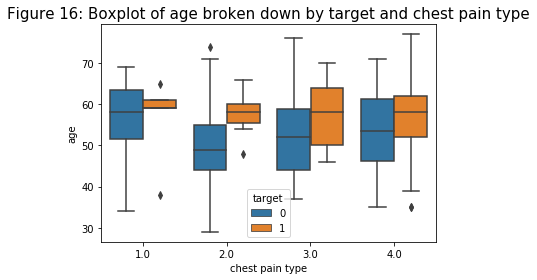

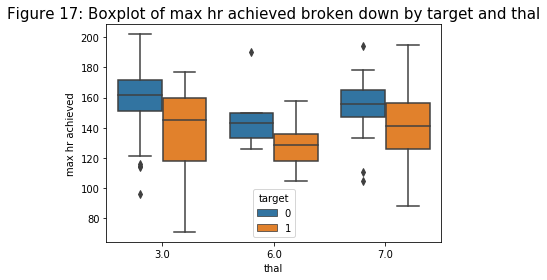

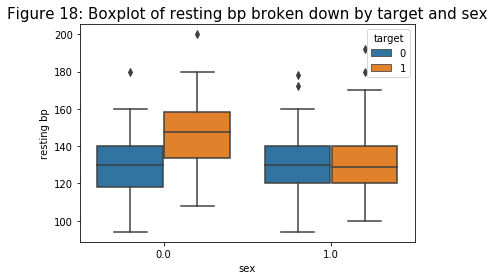

In [105]:
# Show 3 features, where one is numerical (f1) and two is nominal (f2, f3). Notice that f2 levels needs to be max 2 like Gender
def show_4feature_boxplot(data, f1, f2, f3):
    # Getting the index of those who have completed their Bachelors or HS graduate
    levels = data2[f2].unique().tolist()
    f2_mask = data2[f2].isin(levels)

    # Getting the index of those who are male and Not_in_family or a Husband
    levels_f3 = data2[f3].unique().tolist()
    f3_level1_mask = (data2[f3].isin(levels_f3)) & (data2[f2].isin([levels[0]]))
    f3_level2_mask = (data2[f3].isin(levels_f3)) & (data2[f2].isin([levels[1]]))

    # Selecting the rows of those who are Not_in_family, husband or wife and 
    # have completed either a Bachelors or just graduated high school
    f2_f3_mask = data2[(f2_mask & f3_level2_mask) | (f2_mask & f3_level1_mask)]

    # Creating the boxplot
    sns.boxplot(f2_f3_mask[f3], f2_f3_mask[f1], 
                hue = f2_f3_mask[f2])
    plt.title('Figure {}: Boxplot of {} broken down by {} and {}'.format(fignr.pop(0), f1, f2, f3), fontsize = 15)
    plt.show();
    
show_4feature_boxplot(data2, 'age', 'target', 'chest pain type')
show_4feature_boxplot(data2, 'max hr achieved', 'target', 'thal')
show_4feature_boxplot(data2, 'resting bp', 'target', 'sex')

The plots above shows that there is a significant difference in the patients with and without heart disease, when analysing the features Chest Paint Type combined with Age, Maximum Heart Rate Achieved combined with Thal Type and Gender combined with Resting Blood Pressure. However, we must consider the fact that Chest Paint Type 1.0 and 2.0 have very few patients to draw any conclusions on, aswell as Thal variant 6.0. 

To easier display a combination of numerical features a scatter plot has been used. They can present two features that are numerical and one nominal feature, and these are shown below with some different combinations.

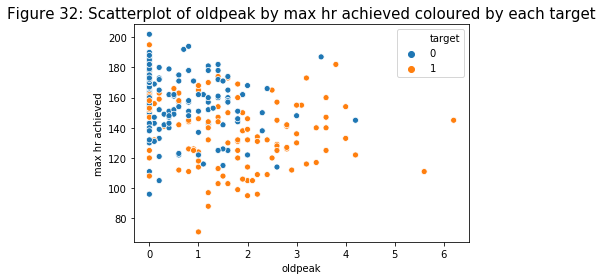

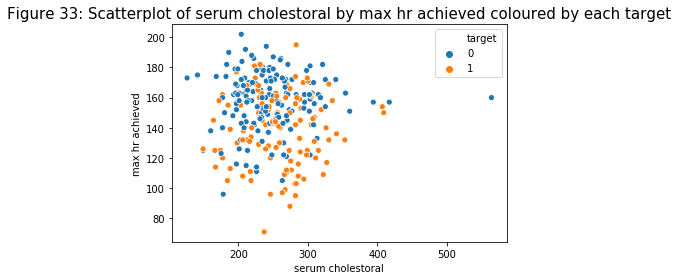

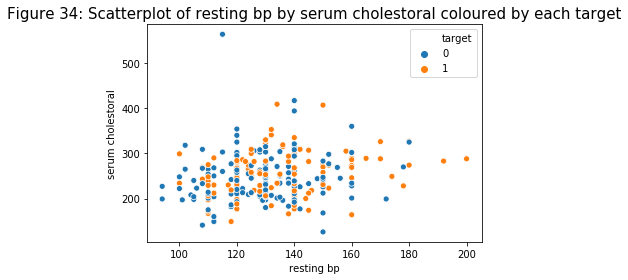

In [110]:
# Show a scatterplot of 3 features where f1 is nominal and f2 and f3 is numerical
def show_scatterplot(data, f1, f2, f3):
    # Getting the index of those in feature 1
    f1_levels = data2[f1].unique().tolist()
    mask = data2[f1].isin(f1_levels)

    # creating a dataframe of those in feature1
    f1_df = data2[mask]

    # creating a scatterplot
    sns.scatterplot(f1_df[f2], f1_df[f3], hue = f1_df[f1])
    plt.title('Figure {}: Scatterplot of {} by {} coloured by each {}'.format(fignr.pop(0), f2, f3, f1), fontsize = 15);
    plt.legend(loc = 'upper right')
    plt.show();

show_scatterplot(data2, 'target', 'oldpeak','max hr achieved')
show_scatterplot(data2, 'target', 'serum cholestoral', 'max hr achieved')
show_scatterplot(data2, 'target', 'resting bp', 'serum cholestoral')

The conclusions from the scatterplots are: 
- Most of the patientw with oldpeak above 1.5 and a maximum heart rate lower than 140 bpm have been diagnosed with a heart disease.
- Same regarding serum cholesteral above 280 and maximum heart rate lower than 140 bpm.
- Any conclusion from serum cholesteral and resting blood pressure can not be drwn.


<a class="anchor" id="pred-mod"></a>
# Predictive Modelling

Now that we are well acquainted with our data and it is had been prepared, we can get to the business of predictive modelling. 

We first select a cross-validation method to use throughout our testing, then moving to optimisation with feature selecting and hyperparameter tuning, before final testing the performance of our optimised models.

<a class="anchor" id="cross-val"></a>
## Cross-Validation
To assess the performance of our models we will be using repeated stratified 5-fold cross-validation with 3 repetitions. Stratified cross-validation was selected to ensure the proportion of positive and negatives labels in the target is preserved in each repetition. 

We have chosen to use the area under the ROC curve as our scoring metric as it is robust to class imbalance, which exists in our target.

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=random_seed)

scoring_metric = 'roc_auc'

<a class="anchor" id="feature-sel"></a>
## Feature Selection
We will optimise our dataset by peforming feature selection. This will be done using random forest importance (RFI) to determine whether an optimal subset of our descriptive features might give better performance. 

In [ ]:
# for plotting
import altair as alt
alt.renderers.enable('notebook')

from sklearn import feature_selection as fs
from sklearn.ensemble import RandomForestClassifier

# intially we wish to asses the importance of all of our features
num_features = 20

model_rfi = RandomForestClassifier(n_estimators=200)
model_rfi.fit(data, encoded_target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

# get all features in sorted order of importance
best_features_rfi = data_copy.columns[fs_indices_rfi].values

# get their importances
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

# plot
df_fs = pd.DataFrame({'features': best_features_rfi, 
                      'importances' : feature_importances_rfi})
    
alt.Chart(df_fs, 
            width=800,
            height=500,
            title='Random Forest Feature Importances',
            ).mark_bar(opacity=0.75, 
                        color='blue').encode(
    alt.X('features', title='features', sort=None, axis=alt.AxisConfig(labelAngle=45)),
    alt.Y('importances', title='importances')
    )

In the above graph we can see the importances of all of our descriptive features sorted in descreasing order of importance. Let us now measure the accuracy of a number of feature subsets to determine if one is optimal using a KNN classifier with the eulidean distance metric and n=5 neighbours.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# our classifier for measuring purposes
fs_knn = KNeighborsClassifier(n_neighbors=5)

# minimum of 5 features, maximum of all of them
num_features = [x for x in range(5,21)]

# record of scores, preserving the order such that i-th entry of num_features corresponds to the i-th entry of fs_scores
fs_scores = list()

for n in num_features:
    
    # subset data into the first n most important features
    subset = data[:, fs_indices_rfi[:n]]
    
    # assess accuracy and record it
    cv_results_fs = cross_val_score(estimator=fs_knn,
                             X=subset,
                             y=encoded_target, 
                             cv=cv_method, 
                             scoring=scoring_metric)

    fs_scores.append(cv_results_fs.mean().round(3))
    
# df of scores in sorted order
acc_df = pd.DataFrame({'num_features': num_features, 
                       'score': fs_scores}).sort_values(by=['score']) 

# get row containing optimal n_features
n_features_optimal = acc_df.iloc[acc_df['score'].argmax()]

# display df
acc_df

In [ ]:
# plot results
alt.Chart(acc_df, 
          width=500,
          height=700,
          title='scores for the n most important features'
         ).mark_line(point=True).encode(
    alt.X('num_features', title='num_features'),
    alt.Y('score', title='Mean CV Score', scale=alt.Scale(zero=False)),
)

Above we see that using the 12 most important features yields us the greatest mean CV score. We therefore subset our data accordingly before proceeding.

In [ ]:
# obtain the value for the optimal number of features
best_n = int(n_features_optimal['num_features'])
# transform the data to include just these features
data = data[:, fs_indices_rfi[:best_n]]
data.shape

<a class="anchor" id="hyper-tun"></a>
## Hyperparameter Tuning
To optimise our models we will perform hyperparameter tuning. The models we will be optimising are: K-nearest neighbours, decision tree, random forest, and naive bayes. Grid search is used to determine optimal parameters and models are trained on the training dataset.

### Train-test Splitting
We require that our data be split into training and testing sets. Note that to preserve the proportion of positive and negative instances of our target across the training and test sets we set the stratify option to the target.

In [ ]:
from sklearn.model_selection import train_test_split

d_train, d_test,t_train, t_test = train_test_split(data, encoded_target, 
                                                    test_size = 0.3, 
                                                    stratify = encoded_target,   
                                                    random_state=random_seed)


### KNN hyperparameter tuning
We begin by defining a set of parameters for tuning our KNN model. We wish to inspect as large a range as possible without incurring too much computational cost.

In [ ]:
from sklearn.model_selection import GridSearchCV

# parameters for KNN tuning
KNN_params = {'n_neighbors' : [x for x in range(1,20)],
             'p' : [1,2,3,4,5]}

# grid search setup
gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=KNN_params, 
                      cv=cv_method,
                      verbose=1,
                      n_jobs=-1,
                      scoring=scoring_metric)

# fit the KNN model using training data
gs_KNN.fit(d_train, t_train)

Now that we have our optimal parameters, let's visualise the results of our hyperparamter tuning and cross-validation. 

In [ ]:
# print results
print(f"The optimal KNN parameters determined by grid search are:\n{gs_KNN.best_params_}\n")
print(f"These parameters give the best score of:{round(gs_KNN.best_score_,3)}\n")

# we build a dataframe to hold the results of our tuning process so that we may plot them
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,3,4,5], ["Manhattan", "Euclidean", "Minkowski3", "Minkowski4", "Minkowski5"])

# plot
alt.Chart(results_KNN, 
          width=1000,
          height=500,
          title='KNN Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('n_neighbors', title='Number of Neighbors'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
    color='metric'
)

From the plot above it's clear to see that increasing the value of p does not improve performance, however at the end of our range of values for n_neighbours it seems as if our accuracy score might increase more. 

We therefore extend our range of values for n_neighbors, reducing our values of p to save on computational time, to see the effect of raising this value. We will check only odd values to save time and to guard against tied-votes.

In [ ]:
# parameters for KNN tuning
KNN_params_further = {'n_neighbors' : [x for x in range(1,80,2)],
             'p' : [1,2]}

# grid search setup
gs_KNN_further = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=KNN_params_further, 
                      cv=cv_method,
                      verbose=1,
                      n_jobs=-1,
                      scoring=scoring_metric)

# fit the KNN model using training data
gs_KNN_further.fit(d_train, t_train)

In [ ]:
# print results
print(f"The optimal KNN parameters determined by grid search are:\n{gs_KNN_further.best_params_}\n")
print(f"These parameters give the best score of:{round(gs_KNN_further.best_score_,3)}\n")

# we build a dataframe to hold the results of our tuning process so that we may plot them
results_KNN_further = pd.DataFrame(gs_KNN_further.cv_results_['params'])
results_KNN_further['test_score'] = gs_KNN_further.cv_results_['mean_test_score']
results_KNN_further['metric'] = results_KNN_further['p'].replace([1,2], ["Manhattan", "Euclidean"])

# plot
alt.Chart(results_KNN_further, 
          width=1000,
          height=500,
          title='KNN Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('n_neighbors', title='Number of Neighbors'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
    color='metric'
)

From the plot of our extended range of values it's clear to see that raising the value of n_neighbors does not significantly increase our mean CV score, with there being virtually no difference between n=9 with a score of 0.91 and n=31 with a score of 0.912. We therefore keep our optimal paramter at n=9.


### Decision Tree
We proceed as before with our decision tree classifier to determine the optimal parameters. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'min_samples_split': [2, 4, 6, 8, 10]}

gs_DT = GridSearchCV(estimator=DecisionTreeClassifier(random_state=random_seed), 
                     param_grid=params_DT, 
                     cv=cv_method,
                     verbose=1, 
                     n_jobs=-1,
                     scoring=scoring_metric)

gs_DT.fit(d_train, t_train)

The plot below shows that the entropy metric appears to outperform the gini metric for this model, with the two becoming approximately the same as max_depth increases and overall performance decreases.

In [ ]:
# display results
print(f"The optimal DT parameters determined by grid search are:\n{gs_DT.best_params_}\n")
print(f"These parameters give the best score of:{gs_DT.best_score_}\n")

# record the results in a dataframe for plotting
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']

# plot
alt.Chart(results_DT, 
          width = 1000,
          height=500,
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('max_depth', title='Maximum Depth'),
    alt.Y('test_score', title='Mean CV Score', aggregate='average', scale=alt.Scale(zero=False)),
    color='criterion:N'
)

Let's also visualise our results in terms of our minimal sample split parameters. We see fairly uniform performance until a max_depth of 3, after which performance for each value diverges and is suboptimal.

In [ ]:
alt.Chart(results_DT, 
          width = 1000,
          height=500, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('max_depth', title='Maximum Depth'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
    color='min_samples_split:N' 
)

### Naive Bayes

One of the assumptions of a Naive Bayes learner is that our descriptive features are at least approximately normally distributed. To normalise our descriptive features for this model we will apply a power transformer to our training data before tuning. This is done below.

In [ ]:
from sklearn.preprocessing import PowerTransformer

# copy the data
NB_d_train = d_train.copy()

# apply the power transformer to the data
NB_d_train = PowerTransformer().fit_transform(NB_d_train)

We're now ready to tune our Naive Bayes learner.

In [ ]:
from sklearn.naive_bayes import GaussianNB

params_NB = {'var_smoothing': np.logspace(1,-11, num=300)}

gs_NB = GridSearchCV(estimator=GaussianNB(), 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     n_jobs=-1,
                     scoring=scoring_metric)

gs_NB.fit(NB_d_train, t_train)

Now we can report our optimal parameters and visualise our results. From the plot below we see that as values of var_smoothing increase performance decreases.

In [ ]:
# display results
print(f"The optimal NB parameters determined by grid search are:\n{gs_NB.best_params_}\n")
print(f"These parameters give the best score of:{round(gs_NB.best_score_,3)}\n")

# create a dataframe for plotting our results
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

# plot
alt.Chart(results_NB, 
          width = 1000,
          height=500,
          title='NB Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('var_smoothing', title='Var. Smoothing'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False))
)

### Random Forest
Lastly we will be tuning a random forest learner. We proceed as before. 

In [ ]:
# parameters
RF_params = {'n_estimators': [50, 100, 200, 300, 400 ,500, 600],
             'max_depth': [2,4,8,16]} 

gs_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=random_seed), 
                     param_grid=RF_params, 
                     cv=cv_method,
                     verbose=1,
                     n_jobs=-1,
                     scoring=scoring_metric)

gs_RF.fit(d_train, t_train)

In [ ]:
# display results
print(f"The optimal RF parameters determined by grid search are:\n{gs_RF.best_params_}\n")
print(f"These parameters give the best score of:{gs_RF.best_score_}\n")

# create a dataframe for plotting our results
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']

# TODO, can squeeze more performance out of this, do little investigation then bigger optimised one

# plot
alt.Chart(results_RF, 
          width = 1000,
          height=500, 
          title='RF Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('n_estimators', title='n_estimators'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
    color='max_depth:N'
)

<a class="anchor" id="model-fit"></a>
# Model Fitting and Performance Evaluation
Now that we have the optimal parameters for our models by training them on the training data, we can not fit them to our test data and evaluate their performance. The aim of this is to evaluate the performance of our learners on data that they have not yet seen, and to then comapre their performance using paired t-tests to determine whether the differences in performance are significant.

## KNN evaluation
We proceed by fitting a KNN learner (with optimised paramters) to our testing data set and evaulating its performance using our chosen cross-validation scheme. We do the same for the other 3 learners below.

In [ ]:
KNN_eval = KNeighborsClassifier(n_neighbors=gs_KNN.best_params_['n_neighbors'],
                                p=gs_KNN.best_params_['p'])

cv_results_KNN = cross_val_score(estimator=KNN_eval,
                                 X=d_test,
                                 y=t_test, 
                                 cv=cv_method, 
                                 n_jobs=-1,
                                 scoring=scoring_metric)
cv_results_KNN.mean()

## Decision Tree evaluation

In [ ]:
DT_eval = DecisionTreeClassifier(criterion=gs_DT.best_params_['criterion'],
                                 max_depth=gs_DT.best_params_['max_depth'],
                                 min_samples_split=gs_DT.best_params_['min_samples_split'],
                                 random_state=random_seed)

cv_results_DT = cross_val_score(estimator=DT_eval,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method, 
                                n_jobs=-1,
                                scoring=scoring_metric)
cv_results_DT.mean()

## Naive Bayes evaluation

In [ ]:
NB_eval = GaussianNB(var_smoothing=gs_NB.best_params_['var_smoothing'])

d_test_transformed = PowerTransformer().fit_transform(d_test)

cv_results_NB = cross_val_score(estimator=NB_eval,
                                X=d_test_transformed,
                                y=t_test, 
                                cv=cv_method, 
                                n_jobs=-1,
                                scoring=scoring_metric)
cv_results_NB.mean()

## Random Forest evaluation

In [ ]:
RF_eval = RandomForestClassifier(n_estimators=gs_RF.best_params_['n_estimators'],
                                 max_depth=gs_RF.best_params_['max_depth'],
                                 random_state=random_seed)

cv_results_RF = cross_val_score(estimator=RF_eval,
                                X=d_test,
                                y=t_test, 
                                cv=cv_method, 
                                n_jobs=-1,
                                scoring=scoring_metric)
cv_results_RF.mean()

## Paired t-tests of model performace 

In [ ]:
from scipy import stats

print("KNN vs NB:",stats.ttest_rel(cv_results_KNN, cv_results_NB))
print("KNN vs DT:",stats.ttest_rel(cv_results_KNN, cv_results_DT))
print("KNN vs RF:",stats.ttest_rel(cv_results_KNN, cv_results_RF))
print("RF vs NB:",stats.ttest_rel(cv_results_RF, cv_results_NB))
print("DT vs NB:",stats.ttest_rel(cv_results_DT, cv_results_NB))
print("RF vs DT:",stats.ttest_rel(cv_results_RF, cv_results_DT))

p < 0.05 indicates a statistically significant difference in performance at a 95% confidence level. All differences are significant except for the Naive Bayes model compared to the Random Forest model, which were the two best learners with a small difference between their scores. 

To try and remedy this, we will re-evaluate both these models using the entire dataset to see if a significant difference arises.

In [ ]:
# re-evaluating the NB model
data_NB_transformed = PowerTransformer().fit_transform(data)

cv_results_NB_again = cross_val_score(estimator=NB_eval,
                                X=data_NB_transformed,
                                y=target, 
                                cv=cv_method, 
                                n_jobs=-1,
                                scoring=scoring_metric)
cv_results_NB_again.mean()

In [ ]:
# re-evaluating the RF model
cv_results_RF_again = cross_val_score(estimator=RF_eval,
                                X=data,
                                y=target, 
                                cv=cv_method, 
                                n_jobs=-1,
                                scoring=scoring_metric)
cv_results_RF_again.mean()

In [ ]:
print(stats.ttest_rel(cv_results_RF_again, cv_results_NB_again))

Here we find p < 0.05, and the Naive Bayes model is the clear winner. 

<a class="anchor" id="discussion"></a>
# Discussion

Using the metrics module from Sci-Kit Learn we can generate the predicitons made by our models on the testing data and examine a number of extra performance metrics.

In [ ]:
from sklearn import metrics

pred_KNN = gs_KNN.predict(d_test)
pred_NB = gs_NB.predict(d_test_transformed)
pred_DT = gs_DT.predict(d_test)
pred_RF = gs_RF.predict(d_test)

<a class="anchor" id="conf-mat"></a>
## Confusion Matrix, precision, recall and F1-score
A confusion matrix will be produced to analyse the outcome of the predictions further. The metrics precision, recall (True Positive Rate) and F1-score are tools to value the results on predictions being made on the test data. These are displayed from the classification_report below for each target.

\#TODO: Check which target is what, makes a big difference on TPR/recall 

In [ ]:
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(t_test, pred_KNN))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(t_test, pred_DT))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(t_test, pred_NB))
print("\nClassification report for Random Forest") 
print(metrics.classification_report(t_test, pred_RF))

Confusion Matrix are built up in a matrix where each item is
- $M_{0,0}$  = True negatives (TN)
- $M_{1,0}$  = False negative (FN)
- $M_{1,1}$  = True positives (TP)
- $M_{0,1}$  = False positives (FP)

As seen in the array below the Confusion Matrix will be shown with values on each positive and negative in that structure.

In [ ]:
np.array([['TN',   'FP'], ['FN',  'TP']])

In [ ]:
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(t_test, pred_KNN))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(t_test, pred_DT))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(t_test, pred_NB))
print("\nConfusion matrix for Random Forest") 
print(metrics.confusion_matrix(t_test, pred_RF))

<a class="anchor" id="roc-curve"></a>
## ROC Curve
The ROC curve is a measurement of different predicitors outcome of the True Positive Rate on the False Positive rate, especially good for analysing Binary Classification problems. The area under the ROC curve (AUC) and the F-score are metrics to show how well the predictor is performing.

Preparing the data for the ROC curve.

In [ ]:
t_prob_KNN = gs_KNN.predict_proba(d_test)
t_prob_DT = gs_DT.predict_proba(d_test)
t_prob_NB = gs_NB.predict_proba(d_test)
t_prob_RF = gs_RF.predict_proba(d_test)
fpr_KNN, tpr_KNN, _ = metrics.roc_curve(t_test, t_prob_KNN[:, 1])
fpr_DT, tpr_DT, _ = metrics.roc_curve(t_test, t_prob_DT[:, 1])
fpr_NB, tpr_NB, _ = metrics.roc_curve(t_test, t_prob_NB[:, 1])
fpr_RF, tpr_RF, _ = metrics.roc_curve(t_test, t_prob_RF[:, 1])

print("AUC for KNN: {}".format(round(metrics.auc(fpr_KNN, tpr_KNN), 3)))
print("AUC for Decision Tree: {}".format(round(metrics.auc(fpr_DT, tpr_DT), 3)))
print("AUC for Naive Bayes: {}".format(round(metrics.auc(fpr_NB, tpr_NB), 3)))
print("AUC for Random Forest: {}".format(round(metrics.auc(fpr_RF, tpr_RF), 3)))

\#TODO: KNN and RF best AUC but very little difference

A dataframe is created for False Positive Rate and True Positive Rate below.

In [ ]:
df_KNN = pd.DataFrame({'fpr': fpr_KNN, 'tpr': tpr_KNN})
df_DT = pd.DataFrame({'fpr': fpr_DT, 'tpr': tpr_DT})
df_NB = pd.DataFrame({'fpr': fpr_NB, 'tpr': tpr_NB})
df_RF = pd.DataFrame({'fpr': fpr_RF, 'tpr': tpr_RF})

Visualizing the ROC curve for each method using Altair.

In [ ]:
base = alt.Chart(df_KNN, 
                 title='ROC Curve of KNN'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

In [ ]:
base = alt.Chart(df_DT, 
                 title='ROC Curve of Decision Tree'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

In [ ]:
base = alt.Chart(df_NB, 
                 title='ROC Curve of Naive Bayes'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

In [ ]:
base = alt.Chart(df_RF, 
                 title='ROC Curve of Random Forest'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

\# TODO: Analysing where the "elbow", the curve bends, towards TPR=1.
The model indicates that it has a good///bad performance.
#TODO: also need to talk about what all these measurements tells us about the models

#TODO: Here I will talk about the limitations etc

Now we turn to a discussion of some of the strengths and weaknesses of our study.

Firstly, while our dataset was complete and fairly clean, it was quite small with only 270 observations. While we lack the expertise to comment on the number and nature of appropriate descriptive features for heart disease we feel safe to say that having a much larger number of observations, say 5000 or so, would increase our confidence in our results. However, despite having
a small dataset we feel our learners performed very well, with their average performance on the testing data given below.

In [ ]:
test_scores = [cv_results_NB.mean(),cv_results_KNN.mean(),cv_results_DT.mean(),cv_results_RF.mean()]
avg_test_score = sum(test_scores)/len(test_scores)
print("The average mean CV score for all models is ",round(avg_test_score,3))

This study could be further improved by examining more machine learning models such as support vector machines and neural networks as it remains to be seen how these models perform, however due to time constraints we were not able to measure them. Computational resources were another limitation, as not wanting to incur too much computational cost we were perhaps restricted in the range of values we could measure as well as the type of cross-validation method we chose. 

<a class="anchor" id="conclusion"></a>
# Conclusion

Our investigation demonstrates that machine learning can be an important tool in diagnostics, with all models examined showing strong predictive power. What we've also seen is that the performance of a machine learning model can be very sensitive to noisy data as well as the exact parameters of the model itself. To address both of these sensitivities we performed feature selection and hyperparameter tuning in a methodical way to maximise performance as much as possible given time and computational constraints. 

Our results show that the performance of the Naive Bayes model was greater than that of the other models, and that this difference in performance was statistically significant. We have therefore achieved our original aim. 

<a class="anchor" id="refs"></a>
# References

UCI Machine Learning Repository. (n.d.). *Statlog (Heart) Data Set*. https://archive.ics.uci.edu/ml/datasets/statlog+%28heart%29